In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

def load_and_concatenate(files):
    # 각 파일별로 DataFrame을 생성하고, 파일명을 Source File 열로 추가
    dfs = [pd.read_excel(file).assign(**{'Source File': file}) for file in files]
    return pd.concat(dfs, ignore_index=True)


def extract_dates_from_filenames(filenames, dataframe):
    dates = []
    for filename in filenames:
        match = re.search(r'\d{8}', filename)  
        if match:
            date = datetime.strptime(match.group(), '%Y%m%d')
        else:
            date = np.nan
        dates.extend([date] * len(dataframe[dataframe['Source File'] == filename]))
    return dates

train_files = ['dataset/updated_trending_videos_final_20240806.xlsx', 'dataset/updated_trending_videos_final_20240811.xlsx', 'dataset/updated_trending_videos_final_20240815.xlsx', 'dataset/updated_trending_videos_final_20240819.xlsx']
valid_files = ['dataset/updated_trending_videos_final_20240807.xlsx', 'dataset/updated_trending_videos_final_20240812.xlsx']
test_files = ['dataset/updated_trending_videos_final_20240810.xlsx', 'dataset/updated_trending_videos_final_20240816.xlsx']


train_df = load_and_concatenate(train_files)
valid_df = load_and_concatenate(valid_files)
test_df = load_and_concatenate(test_files)

train_df['Upload Date'] = extract_dates_from_filenames(train_files, train_df)
valid_df['Upload Date'] = extract_dates_from_filenames(valid_files, valid_df)
test_df['Upload Date'] = extract_dates_from_filenames(test_files, test_df)


# Duration Category: 비디오 길이 범주화
def categorize_duration(duration):
    if duration < 300:  # 5분 미만
        return 'Short'
    elif duration < 1200:  # 5분 이상 20분 미만
        return 'Medium'
    else:  # 20분 이상
        return 'Long'

train_df['Duration Category'] = train_df['Duration'].apply(categorize_duration)
valid_df['Duration Category'] = valid_df['Duration'].apply(categorize_duration)
test_df['Duration Category'] = test_df['Duration'].apply(categorize_duration)

# Duration to Views Ratio: 비디오 길이를 조회수로 나눈 비율
train_df['Duration to Views Ratio'] = train_df['Duration'] / train_df['Views']
valid_df['Duration to Views Ratio'] = valid_df['Duration'] / valid_df['Views']
test_df['Duration to Views Ratio'] = test_df['Duration'] / test_df['Views']

# Likes to Views Ratio: 조회수 대비 좋아요의 비율
train_df['Likes to Views Ratio'] = train_df['Likes'] / train_df['Views']
valid_df['Likes to Views Ratio'] = valid_df['Likes'] / valid_df['Views']
test_df['Likes to Views Ratio'] = test_df['Likes'] / test_df['Views']

# Weekday/Weekend: 비디오가 평일에 업로드되었는지, 주말에 업로드되었는지 여부
def get_weekday_or_weekend(upload_date):
    if pd.isna(upload_date):
        return np.nan
    return 'Weekend' if upload_date.weekday() >= 5 else 'Weekday'

train_df['Weekday/Weekend'] = train_df['Upload Date'].apply(get_weekday_or_weekend)
valid_df['Weekday/Weekend'] = valid_df['Upload Date'].apply(get_weekday_or_weekend)
test_df['Weekday/Weekend'] = test_df['Upload Date'].apply(get_weekday_or_weekend)

# Day of Week: 업로드된 요일
train_df['Day of Week'] = train_df['Upload Date'].dt.day_name()
valid_df['Day of Week'] = valid_df['Upload Date'].dt.day_name()
test_df['Day of Week'] = test_df['Upload Date'].dt.day_name()

train_df = train_df.drop(columns=['Source File'])
valid_df = valid_df.drop(columns=['Source File'])
test_df = test_df.drop(columns=['Source File'])


print("Train Data:")
print(train_df.head())
print("\nValidation Data:")
print(valid_df.head())
print("\nTest Data:")
print(test_df.head())


Train Data:
      Video ID                                              Title  \
0  UZvXqTqp8Jc                 ※이영자편 미방분 대공개※ 김숙 때문에 울 뻔한 이영자...?   
1  UPrkC1LdlLY   Survive 100 Days In Nuclear Bunker, Win $500,000   
2  57S8amIPohQ  리얼한 출산 현장🤰🏻 진통부터 출산까지! 둘째 이름은? K의료진과 힘주기, 둘째 자...   
3  TlOrBtBLwFI                                         아 계곡 물 막혔네   
4  DW-PhGosLA0                        [sub]그런 시기를 어찌 버텼니 도연아....!   

   Category ID   Category Name      Views      Likes  Duration Upload Date  \
0           24   Entertainment     477259     9897.0       677  2024-08-06   
1           24   Entertainment  100161945  3904416.0      1941  2024-08-06   
2           22  People & Blogs     348472    12470.0      1230  2024-08-06   
3           23          Comedy     766929     8577.0       257  2024-08-06   
4           24   Entertainment     499373     8432.0      2945  2024-08-06   

  Duration Category  Duration to Views Ratio  Likes to Views Ratio  \
0            Medium               

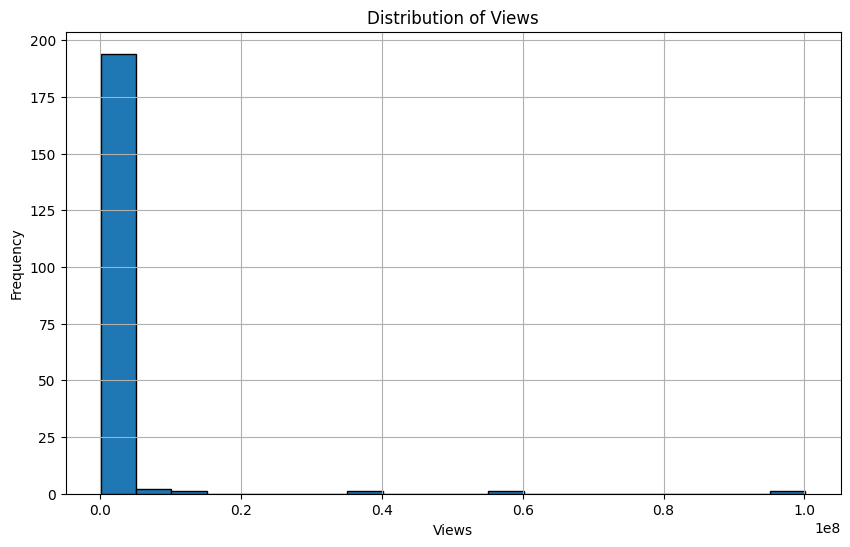

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_df['Views'].dropna(), bins=20, edgecolor='k')
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


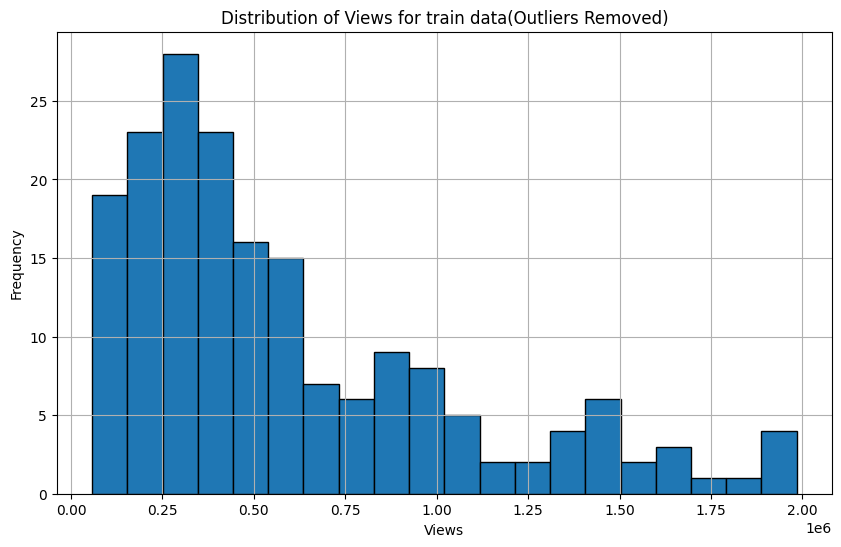

In [3]:
# IQR 방법으로 이상치 제거
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cleaned_train_df = remove_outliers(train_df, 'Views')

# 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(cleaned_train_df['Views'], bins=20, edgecolor='k')
plt.title('Distribution of Views for train data(Outliers Removed)')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


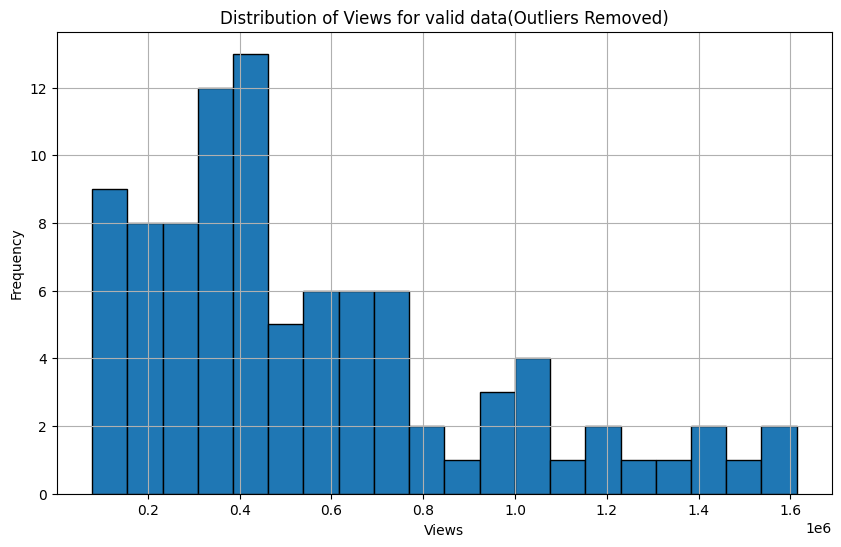

In [4]:
cleaned_valid_df = remove_outliers(valid_df, 'Views')

# 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(cleaned_valid_df['Views'], bins=20, edgecolor='k')
plt.title('Distribution of Views for valid data(Outliers Removed)')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


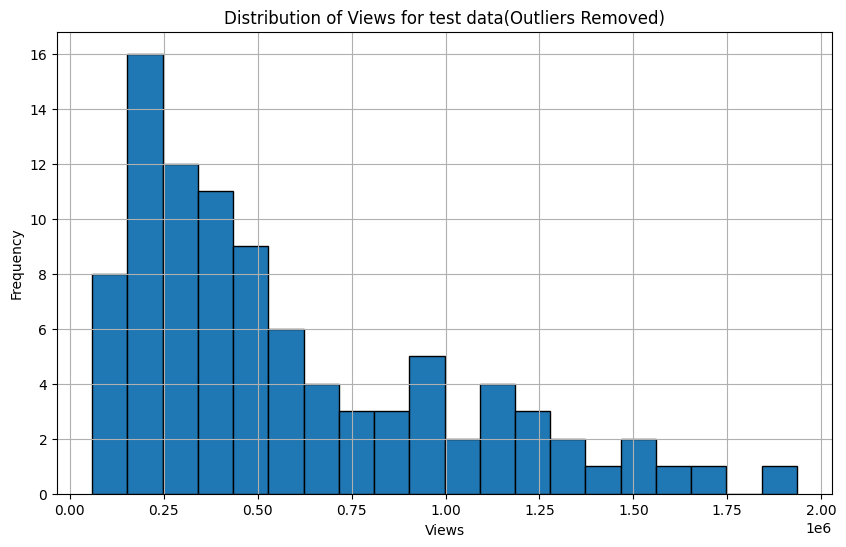

In [5]:
cleaned_test_df = remove_outliers(test_df, 'Views')

# 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(cleaned_test_df['Views'], bins=20, edgecolor='k')
plt.title('Distribution of Views for test data(Outliers Removed)')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [6]:
train_df = cleaned_train_df.sort_values('Views')  # 조회수 기준으로 오름차순 정렬
train_df = cleaned_train_df.drop_duplicates(subset='Video ID', keep='first')  # 중복된 Video ID에서 첫 번째(조회수가 낮은 것)만 남김

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 194
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Video ID                 171 non-null    object        
 1   Title                    172 non-null    object        
 2   Category ID              172 non-null    int64         
 3   Category Name            172 non-null    object        
 4   Views                    172 non-null    int64         
 5   Likes                    169 non-null    float64       
 6   Duration                 172 non-null    int64         
 7   Upload Date              172 non-null    datetime64[ns]
 8   Duration Category        172 non-null    object        
 9   Duration to Views Ratio  172 non-null    float64       
 10  Likes to Views Ratio     169 non-null    float64       
 11  Weekday/Weekend          172 non-null    object        
 12  Day of Week              172 non-null    

In [7]:
valid_df = cleaned_valid_df.sort_values('Views')  # 조회수 기준으로 오름차순 정렬
valid_df = cleaned_valid_df.drop_duplicates(subset='Video ID', keep='first')  # 중복된 Video ID에서 첫 번째(조회수가 낮은 것)만 남김

valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 97
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Video ID                 88 non-null     object        
 1   Title                    89 non-null     object        
 2   Category ID              89 non-null     int64         
 3   Category Name            89 non-null     object        
 4   Views                    89 non-null     int64         
 5   Likes                    88 non-null     float64       
 6   Duration                 89 non-null     int64         
 7   Upload Date              89 non-null     datetime64[ns]
 8   Duration Category        89 non-null     object        
 9   Duration to Views Ratio  89 non-null     float64       
 10  Likes to Views Ratio     88 non-null     float64       
 11  Weekday/Weekend          89 non-null     object        
 12  Day of Week              89 non-null     ob

In [8]:
test_df = cleaned_test_df.sort_values('Views')  # 조회수 기준으로 오름차순 정렬
test_df = cleaned_test_df.drop_duplicates(subset='Video ID', keep='first')  # 중복된 Video ID에서 첫 번째(조회수가 낮은 것)만 남김

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 98
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Video ID                 90 non-null     object        
 1   Title                    91 non-null     object        
 2   Category ID              91 non-null     int64         
 3   Category Name            91 non-null     object        
 4   Views                    91 non-null     int64         
 5   Likes                    89 non-null     float64       
 6   Duration                 91 non-null     int64         
 7   Upload Date              91 non-null     datetime64[ns]
 8   Duration Category        91 non-null     object        
 9   Duration to Views Ratio  91 non-null     float64       
 10  Likes to Views Ratio     89 non-null     float64       
 11  Weekday/Weekend          91 non-null     object        
 12  Day of Week              91 non-null     ob

In [9]:
# 범주형 변수(Video ID, Title)는 큰 영향을 안 미칠 것으로 보아 drop
drop_cols = ['Video ID', 'Title','Upload Date']
# train_df_num = augmented_train_df.drop(columns=drop_cols)
# valid_df_num = augmented_valid_df.drop(columns=drop_cols)
# test_df_num = augmented_test_df.drop(columns=drop_cols)

train_df_num = train_df.drop(columns=drop_cols)
valid_df_num = valid_df.drop(columns=drop_cols)
test_df_num = test_df.drop(columns=drop_cols)

In [10]:
train_df_num.dropna(axis=0, inplace=True)
valid_df_num.dropna(axis=0, inplace=True)
test_df_num.dropna(axis=0, inplace=True)

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 수치형 변수 목록
numerical_cols = ['Likes', 'Duration', 'Duration to Views Ratio', 'Likes to Views Ratio']

# 범주형 변수들을 레이블 인코딩 (Category Name)
label_encoder = LabelEncoder()
train_df_num['Category Name'] = label_encoder.fit_transform(train_df_num['Category Name'])
valid_df_num['Category Name'] = label_encoder.transform(valid_df_num['Category Name'])
test_df_num['Category Name'] = label_encoder.transform(test_df_num['Category Name'])

# 나머지 범주형 변수들을 원핫 인코딩
train_df_encoded = pd.get_dummies(train_df_num, columns=['Duration Category', 'Weekday/Weekend', 'Day of Week'])
valid_df_encoded = pd.get_dummies(valid_df_num, columns=['Duration Category', 'Weekday/Weekend', 'Day of Week'])
test_df_encoded = pd.get_dummies(test_df_num, columns=['Duration Category', 'Weekday/Weekend', 'Day of Week'])

# train, valid, test 데이터셋의 열을 일관되게 유지
valid_df_encoded = valid_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

# StandardScaler를 사용하여 수치형 변수만 스케일링
scaler = StandardScaler()

# 수치형 변수만 스케일링하여 새로운 DataFrame 생성
train_df_scaled = train_df_encoded.copy()
train_df_scaled[numerical_cols] = scaler.fit_transform(train_df_encoded[numerical_cols])

valid_df_scaled = valid_df_encoded.copy()
valid_df_scaled[numerical_cols] = scaler.transform(valid_df_encoded[numerical_cols])

test_df_scaled = test_df_encoded.copy()
test_df_scaled[numerical_cols] = scaler.transform(test_df_encoded[numerical_cols])


In [12]:
train_df_scaled.columns

Index(['Category ID', 'Category Name', 'Views', 'Likes', 'Duration',
       'Duration to Views Ratio', 'Likes to Views Ratio',
       'Duration Category_Long', 'Duration Category_Medium',
       'Duration Category_Short', 'Weekday/Weekend_Weekday',
       'Weekday/Weekend_Weekend', 'Day of Week_Monday', 'Day of Week_Sunday',
       'Day of Week_Thursday', 'Day of Week_Tuesday'],
      dtype='object')

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Views의 평균 및 표준편차 계산
summary_stats = train_df_scaled.groupby('Category Name')['Views'].agg(['mean', 'std']).reset_index()

# 결과 확인
print(summary_stats)


    Category Name           mean            std
0               0  991674.166667  510324.146938
1               1  635138.153846  474158.823420
2               2  874087.666667  765968.859311
3               3  341408.250000  102391.140682
4               4  179161.166667   36475.135917
5               5  578095.181818  570275.052915
6               6  899684.500000  628252.354269
7               7  422962.355932  280770.965438
8               8  324916.000000            NaN
9               9  475680.000000            NaN
10             10  758000.000000  543830.796886
11             11  971767.875000  594254.982221


In [15]:
# 레이블 인코더 클래스 확인
categories = label_encoder.classes_

# 결과 출력
for index, category in enumerate(categories):
    print(f"{index}: {category}")

0: Comedy
1: Entertainment
2: Film & Animation
3: Gaming
4: Howto & Style
5: Music
6: News & Politics
7: People & Blogs
8: Pets & Animals
9: Science & Technology
10: Sports
11: Travel & Events


In [16]:
category_counts = train_df_num['Category Name'].value_counts()
print(category_counts)

Category Name
7     59
1     52
0     12
5     11
10    10
11     8
4      6
3      4
2      3
6      2
9      1
8      1
Name: count, dtype: int64
